In [1]:
from numpy import linalg as LA
import matplotlib.pyplot as plt
import sys
import os, shutil                         # For issuing commands to the OS.
from os import listdir
from os.path import isfile, join
import time
import random
from matplotlib.font_manager import FontProperties
import pandas as pd
import csv
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from scipy.optimize import curve_fit
from scipy.stats import bernoulli
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
#from sklearn.metrics import confusion_matrixfrom sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from io import BytesIO
import boto3
import urllib
import netCDF4 as nc
from netCDF4 import MFDataset
import urllib.request
from time import sleep
import requests
from netCDF4 import Dataset
import timeit

#import ccgfilt_cor
plt.ion() 

# t, latitude = 256, longitude = 512
# p = 37
# p = 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650, 600, 550, 500, 450, 400, 350,300, 250, 
#     225, 200, 175, 150, 125, 100, 70, 50,30, 20, 10, 7, 5, 3, 2, 1 ;
#-------------------------------------------------------------------------------------------------------------
# there are 37 pressure height levels
# select pressure height and latitude levels
pr0 =  0 #7 # 400mb
pr1 =  25 # 15
lat0 = 50 # 10 #150  # 5 # input in degrees N, must be more southward than lat1
lat1 = 60 #60 #200# 60  # 90
len_lat = 256
# initial pressure array:
p_ = np.array([1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650, 600, 550, 500, 450, 400, 350,300, 250, 
     225, 200, 175, 150, 125, 100, 70, 50,30, 20, 10, 7, 5, 3, 2, 1]) 
p_0 = np.array([p_[i] for i in range(25) ])
print(p_0,len(p_0))
p_00 = p_0[::2]
print(p_00, len(p_00))

[1000  975  950  925  900  875  850  825  800  775  750  700  650  600
  550  500  450  400  350  300  250  225  200  175  150] 25
[1000  950  900  850  800  750  650  550  450  350  250  200  150] 13


In [2]:
def Regression_line(arr_x,arr_y,l):
             axes = plt.gca()
             slope, intercept, r_value1, p_value, std_err = stats.linregress(arr_x,arr_y)
             #x_line = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],16)
             
             x_line = np.linspace(min(arr_x),max(arr_x),l) 
             Regr_line = slope*x_line + intercept
             
             Regr_plus_err = (slope + std_err)*x_line + intercept 
             Regr_minus_err = (slope - std_err)*x_line + intercept 
             return slope,x_line,Regr_line,Regr_plus_err,Regr_minus_err,std_err
            

In [52]:
import ccgfilt_corr2
%matplotlib inline
#cutoff = 100# np.array([80,40])

year0=1979
year_list = [(year0+i) for i in range(40)]

#'Circ1_'+str(j)+'.txt'
#file_name = 'Tno_'+str(j)+'__.txt'

total_cir = np.array([]).reshape((0,25,14))
for j in year_list: # for each day the field is (pr,lats) =(25,14)-dimensional
    #print('-------------------')
    #print(' year',j)
    tot_cir = np.loadtxt('Tno_'+str(j)+'__.txt')    
    # (nb of days, 9125/25, 14)
    #print('new textfile has shape',np.shape(tot_cir),type(tot_cir))
    tot_cir = np.reshape(tot_cir, (int(tot_cir.shape[0]/25.),25,14))
    #print('reshaped new file     ',np.shape(tot_cir),type(tot_cir))
    #print('concatenate           ',np.shape(total_cir),np.shape(tot_cir))
    total_cir = np.append(total_cir, tot_cir, axis = 0)
    #print('appended              ',np.shape(total_cir),type(total_cir))    
#total_cir_ = np.asarray(total_cir)
print('total',np.shape(total_cir))


total (14455, 25, 14)


plot
plot pr= 0
plot pr= 0


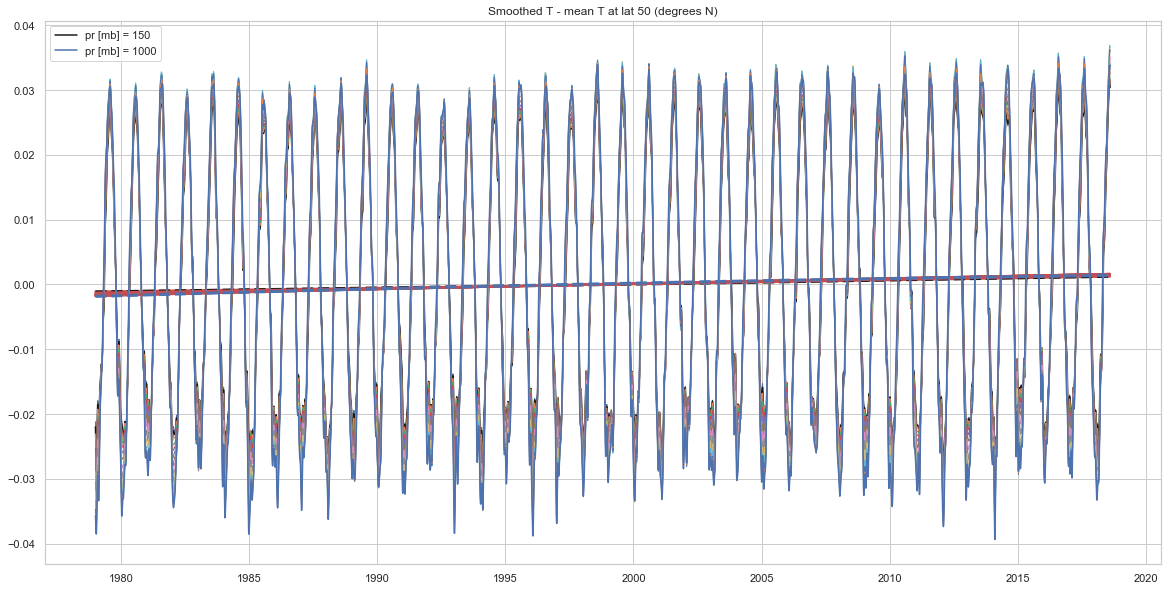

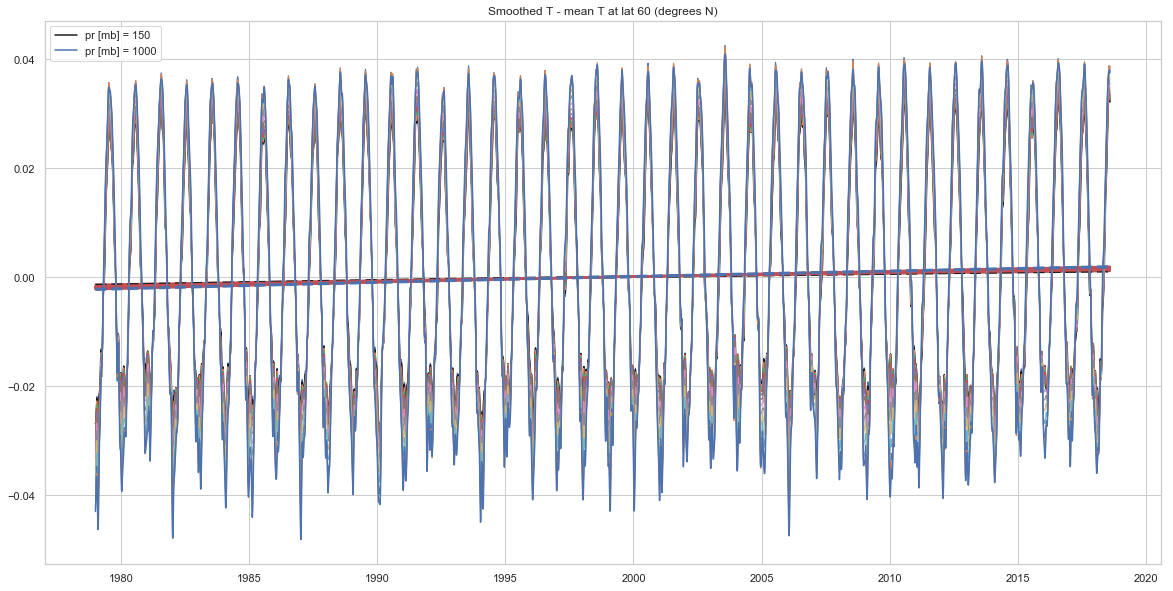

In [56]:
time = np.array([1979+t/365. for t in range(total_cir.shape[0])])
time_all = np.array([1979+t for t in range(total_cir.shape[0])]) # all days
print('plot')
                                                                                               
#plt.plot(time,Regr_line,'b-',linewidth =1.0,label=('k = %4.2f +/- %4.2f' %(slope,std)))                                            
#-------------
def get_object(time, total_field,ccgfilt_corr2):
    obj = ccgfilt_corr2.ccgFilter(time, total_field,shortterm=300,longterm=10000) #filename.classname
    sc_cir = obj.getSmoothValue(time)         # smoothed curve
    trend_cir  = obj.getTrendValue(time)      #
    poly_cir = obj.getPolyValue(time)  
    #ampl_cir = obj.getAmplitudes() 
    # ampl...A list of tuples, each tuple has 6 values (year, total_amplitude, max_date, max_value, min_date, min_value)
    #fun_cir = obj.getFunctionValue(time)
    return sc_cir,trend_cir,poly_cir

def lat_to_grid(latNorth,len_lat):
        # latNorth is the latitude North counted from the equator, whereas the files start counting coordinates 
        # from the Nort pole
        grid_length_in_degrees = 180/float(len_lat) # nb of degrees per latitude grid coordinate 
        grid_coordinate = int((90-latNorth)/float(grid_length_in_degrees))# given the latitude in degrees N, what is the 
        return grid_coordinate                                     # coordinate index of the given nc.file?

    
latNorth = [lat0,lat1]   
lat_ = [0,total_cir.shape[2]-1]

#pr0 =  0 #7 # 400mb
#pr1 =  25 # 15
#lat0 = 50 # 10 #150  # 5 # input in degrees N, must be more southward than lat1
#lat1 = 60 #60 #200# 60  # 90
#len_lat = 256
# initial pressure array:
#p_ = np.array([1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650, 600, 550, 500, 450, 400, 350,300, 250, 
#     225, 200, 175, 150, 125, 100, 70, 50,30, 20, 10, 7, 5, 3, 2, 1]) 
#p_0 = np.array([p_[i] for i in range(25) ])
#print(p_0,len(p_0))
#p_00 = p_0[::2]
#print(p_00, len(p_00))

for la in range(2):
  lats = lat_to_grid(latNorth[la],len_lat)
  lat = lat_[la] 
  plt.figure(figsize=(20,10)) 
  for pres in range(len(p_00),-1,-1):    
   #if pres == 0:
   tot_mean = np.mean(total_cir[:,pres,lat])

   sc,trend,poly = get_object(time_all, total_cir[:,pres,lat]-tot_mean,ccgfilt_corr2)    
   if pres == len(p_00)-1:    
        plt.plot(time , trend/365.,'k-',linewidth=1.5,label = 'pr [mb] = %d' %p_00[pres]) 
        plt.plot(time , poly/365.,'k--',linewidth=3.0)
   elif pres != 0:    
        plt.plot(time , trend/365.,linewidth=1.0) 
        plt.plot(time , poly/365.,'r-',linewidth=2.0)
   if pres == 0:
        print('plot pr=',pres)
        plt.plot(time , trend/365.,'b-',linewidth=1.5,label = 'pr [mb] = %d' %p_00[pres])  
        plt.plot(time , poly/365.,'b--',linewidth=3.0)
  #color=next(ax._get_lines.color_cycle) 
  #plt.ylim(-0.05,0.05)
  plt.title('Smoothed T - mean T at lat %d (degrees N)' %latNorth[la])
  plt.legend()
  plt.savefig('T_total_poly_and_fct_lat'+str(latNorth[la])+'__.png')
#-------------

In [ ]:
print('now plot regression line for arrays x= ',len(time_all),'y=',len(total_cir[:,pr,lat]))

slope,x_line,Regr_line,Regr_plus_err,Regr_minus_err,std = Regression_line(time_all,total_cir[:,pr,lat],len(time_all)) 
print('slope',slope,'std',std)

plt.figure(figsize=(20,10)) 

plt.plot(time_all, total_cir[:,pr,lat],'b-',markersize= 2.0)                                                                                                 
plt.plot(time_all,Regr_line,'r-',linewidth =3.0,label=('k (e-5) = %5.3f +/- %5.3f' %(slope*1.0e5,std*1.0e5)))                                            
#plt.ylim(-25,10)
plt.legend()
plt.savefig("Temp_regression_lat40-70.png")


analysis for years [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
(40,)
shape [(365,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (364,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (365,), (366,), (364,), (365,), (365,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (365,), (366,), (365,), (212,)]
concatenate circulation
shape of concatenated circ (14455,)
plot
shortterm 300
dinterval 0.002739726027397254
<class 'int'>
<class 'int'>


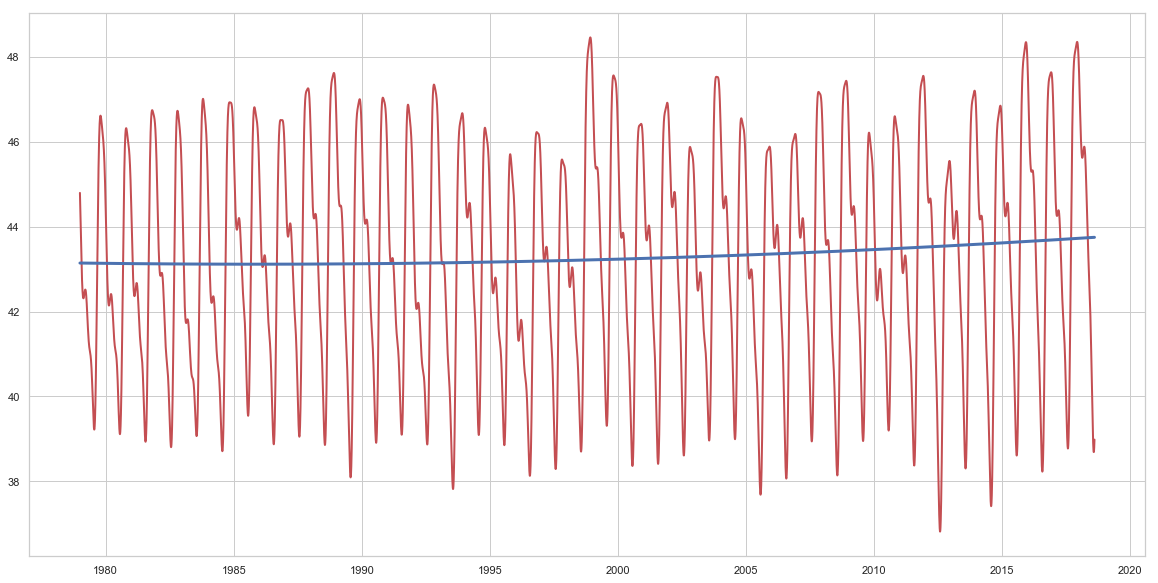